# DSCI Group Project Proposal - Pulsar Stars

_Group 66 (Andrew Ahn, Calvin Choi, Allan Hu, Dishika Taneja_)

Pulsar stars are rapidly rotating neutron stars that emit electromagnetic waves from its poles. As it spins, the "beam" of electromagnetic waves sweeps across Earth in the form of radio waves.

These stars can be measured and found based on the radio waves that they release, but since many radio signals received by our measuring devices are caused by interference or noise and there are so many of them, it is very time consuming to determine whether a signal is a pulsar star or not. In this project, we will make a model that predicts whether a radio observation is a pulsar star.

To do this, we will use the HTRU2 data set from the UC Irving Machine Learning Repository. This dataset features 1,639 actual pulsar star observations and 16,259 observations of noise. The measured data for each observation includes mean, standard deviation, excess kurtosis, and skew for both the pulse profile and the DM-SNR curve of the signal.

### Introduction ###

### Abstract (Preliminary exploratory data analysis)

In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
signals <- read_csv("data/HTRU_2.csv", col_names = FALSE) |>
    rename(profile_mean = X1, profile_std = X2, profile_exk = X3, profile_skew = X4,
                       curve_mean = X5, curve_std = X6, curve_exk = X7, curve_skew = X8, class = X9)
signals_set <- signals |>
    mutate(class = as_factor(class))
signals_set

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


profile_mean,profile_std,profile_exk,profile_skew,curve_mean,curve_std,curve_exk,curve_skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


The last column shows the class, where 1 indicates a pulsar star and 0 indicates noise or interference.

In [3]:
signals_split <- initial_split(signals_set, prop = 0.75, strata = class)
signals_training <- training(signals_split)
signals_testing <- testing(signals_split)
signals_training
signals_means <- signals_training |>
    select(!class) |>
    map_df(mean)
signals_means #Can be used to decide if normalization is needed.
signals_class <- signals_training |>
    group_by(class) |>
    summarize(n = n())
signals_class #Shows how many pulsars there are and how many noise signals there are in the training set.

profile_mean,profile_std,profile_exk,profile_skew,curve_mean,curve_std,curve_exk,curve_skew,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,16.409699,44.62689,2.945244,8.297092,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


profile_mean,profile_std,profile_exk,profile_skew,curve_mean,curve_std,curve_exk,curve_skew
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
110.89,46.46707,0.4852575,1.810867,12.50684,26.17811,8.336214,105.3852


class,n
<fct>,<int>
0,12182
1,1241


To find the best variables, we can analyse the variables in pairs and see which two variables best separate pulsar stars from noise radio signals.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



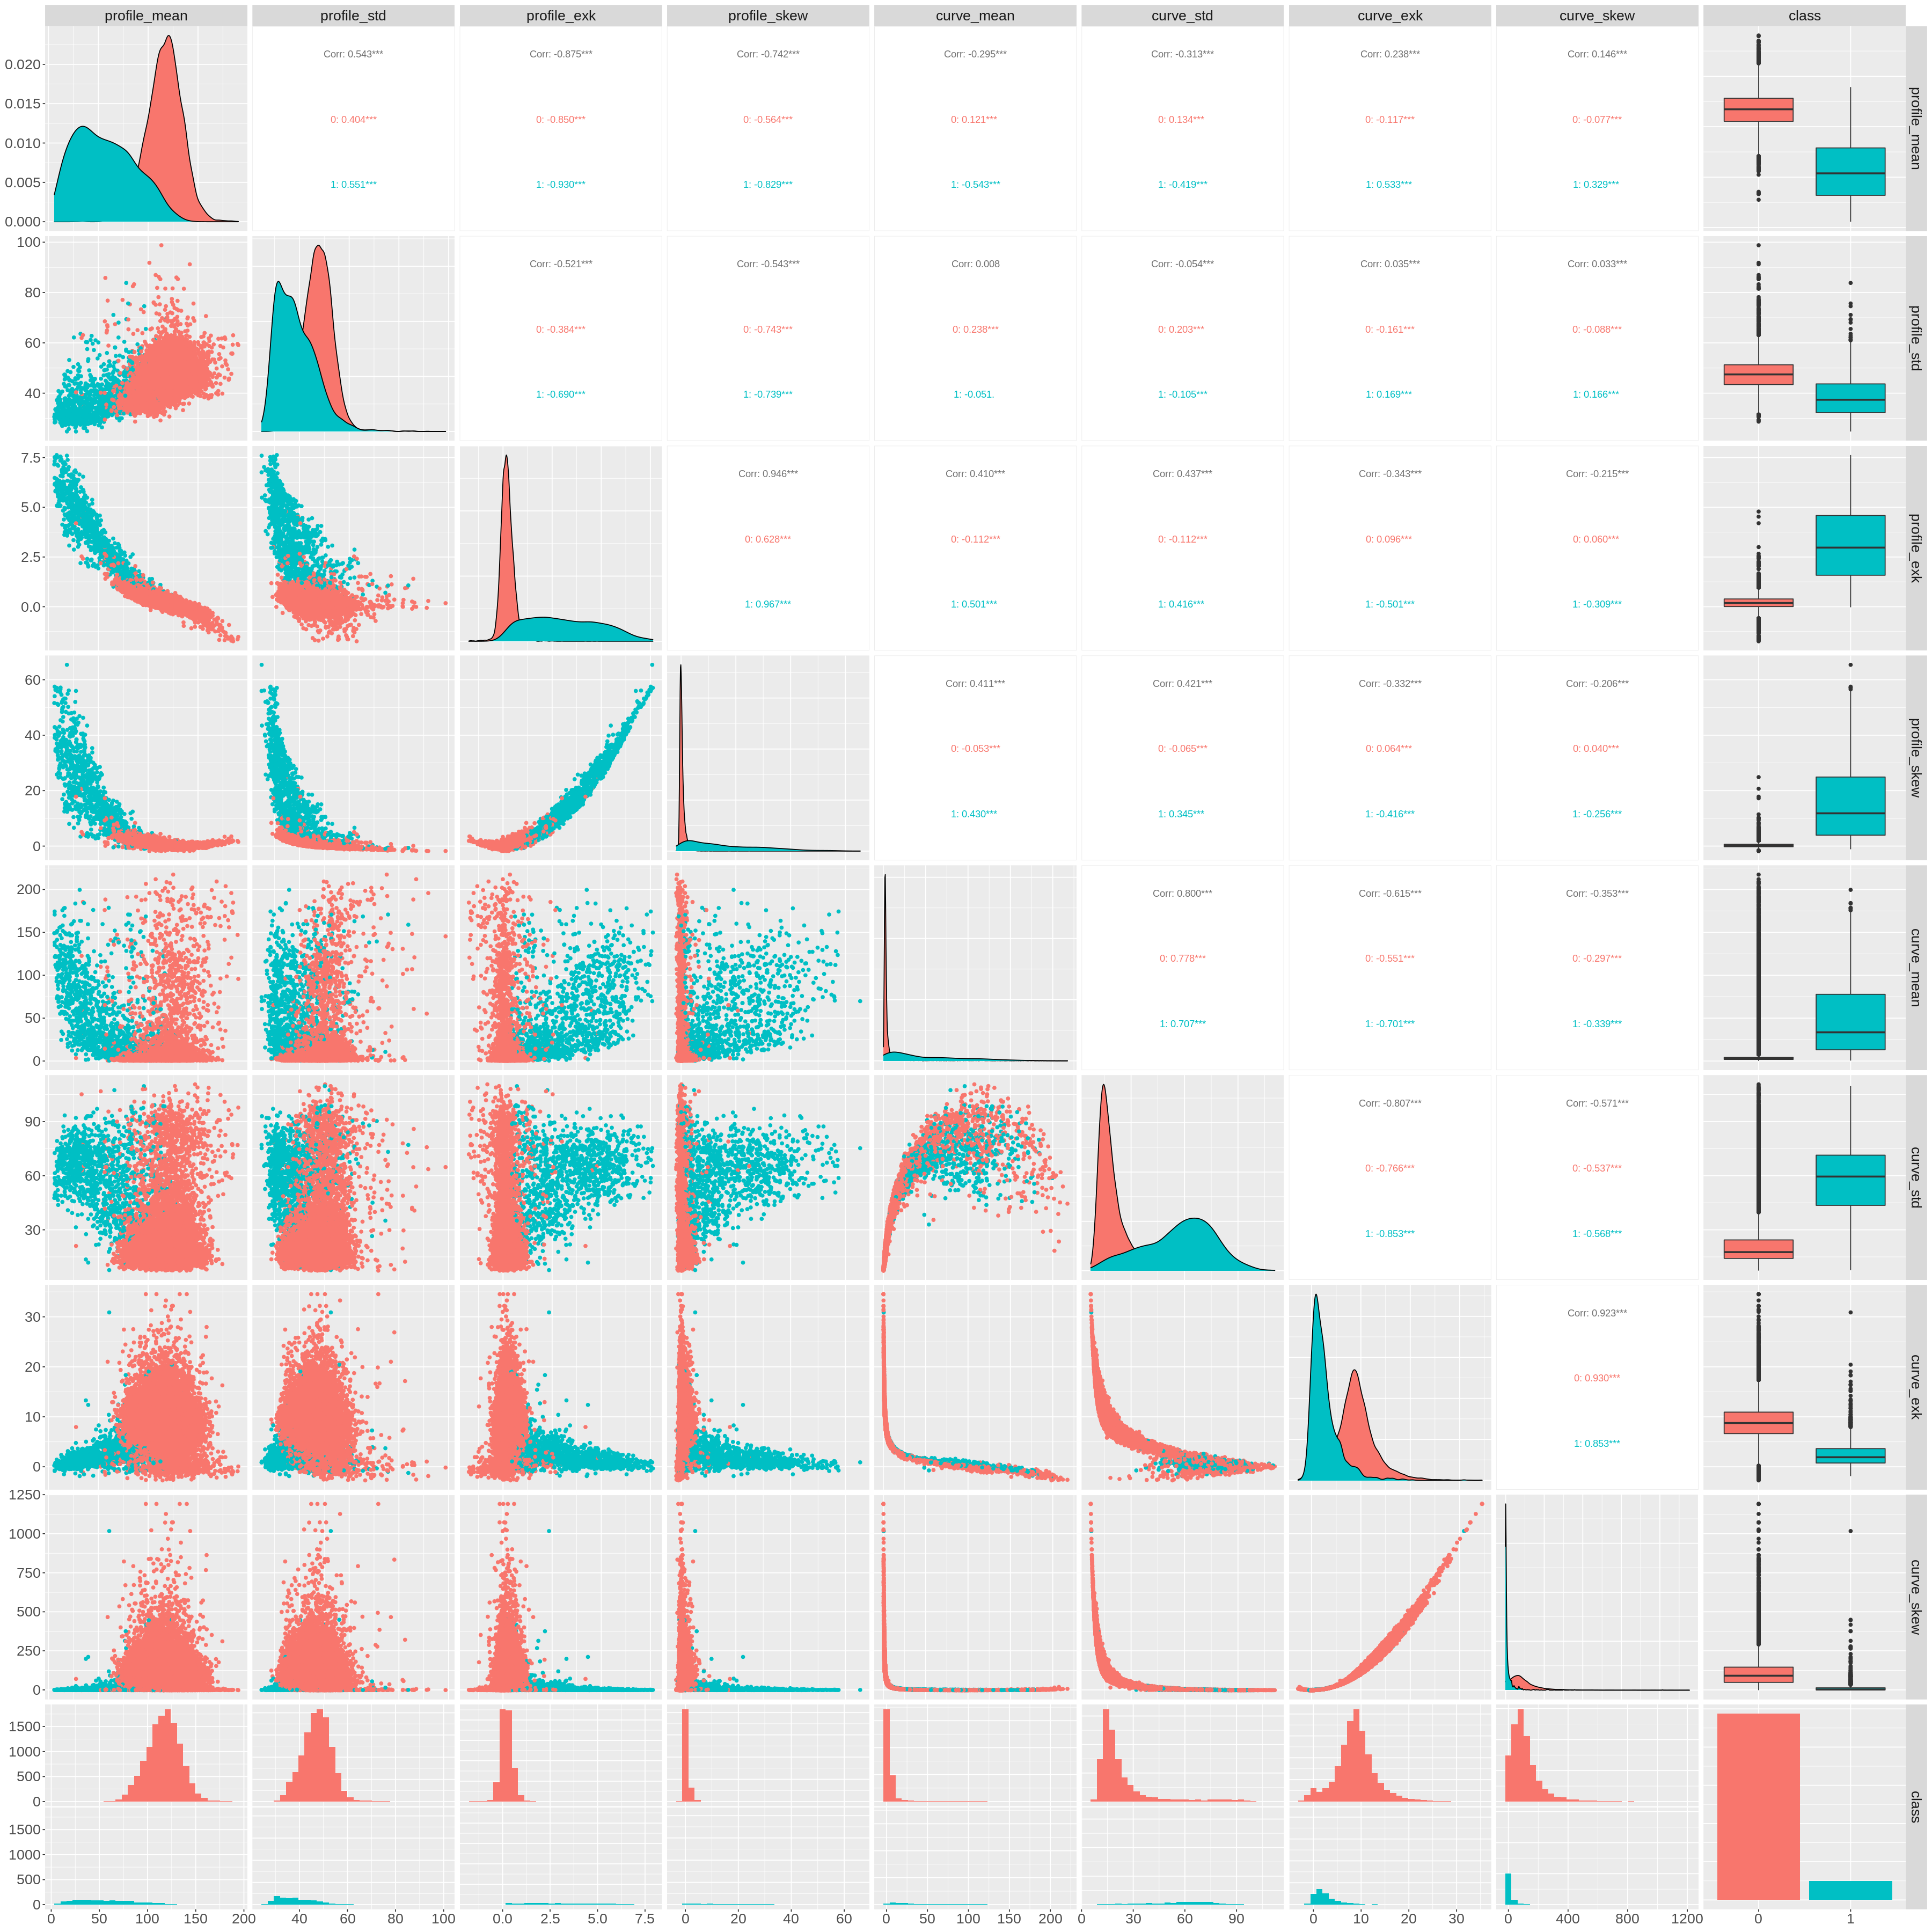

In [8]:
analysis_plot <- signals_training |>
                #select(!profile_mean:profile_skew) |>
                ggpairs(aes(color = class)) +
                theme(text = element_text(size = 20))

options(repr.plot.width = 30, repr.plot.height = 30) 
analysis_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



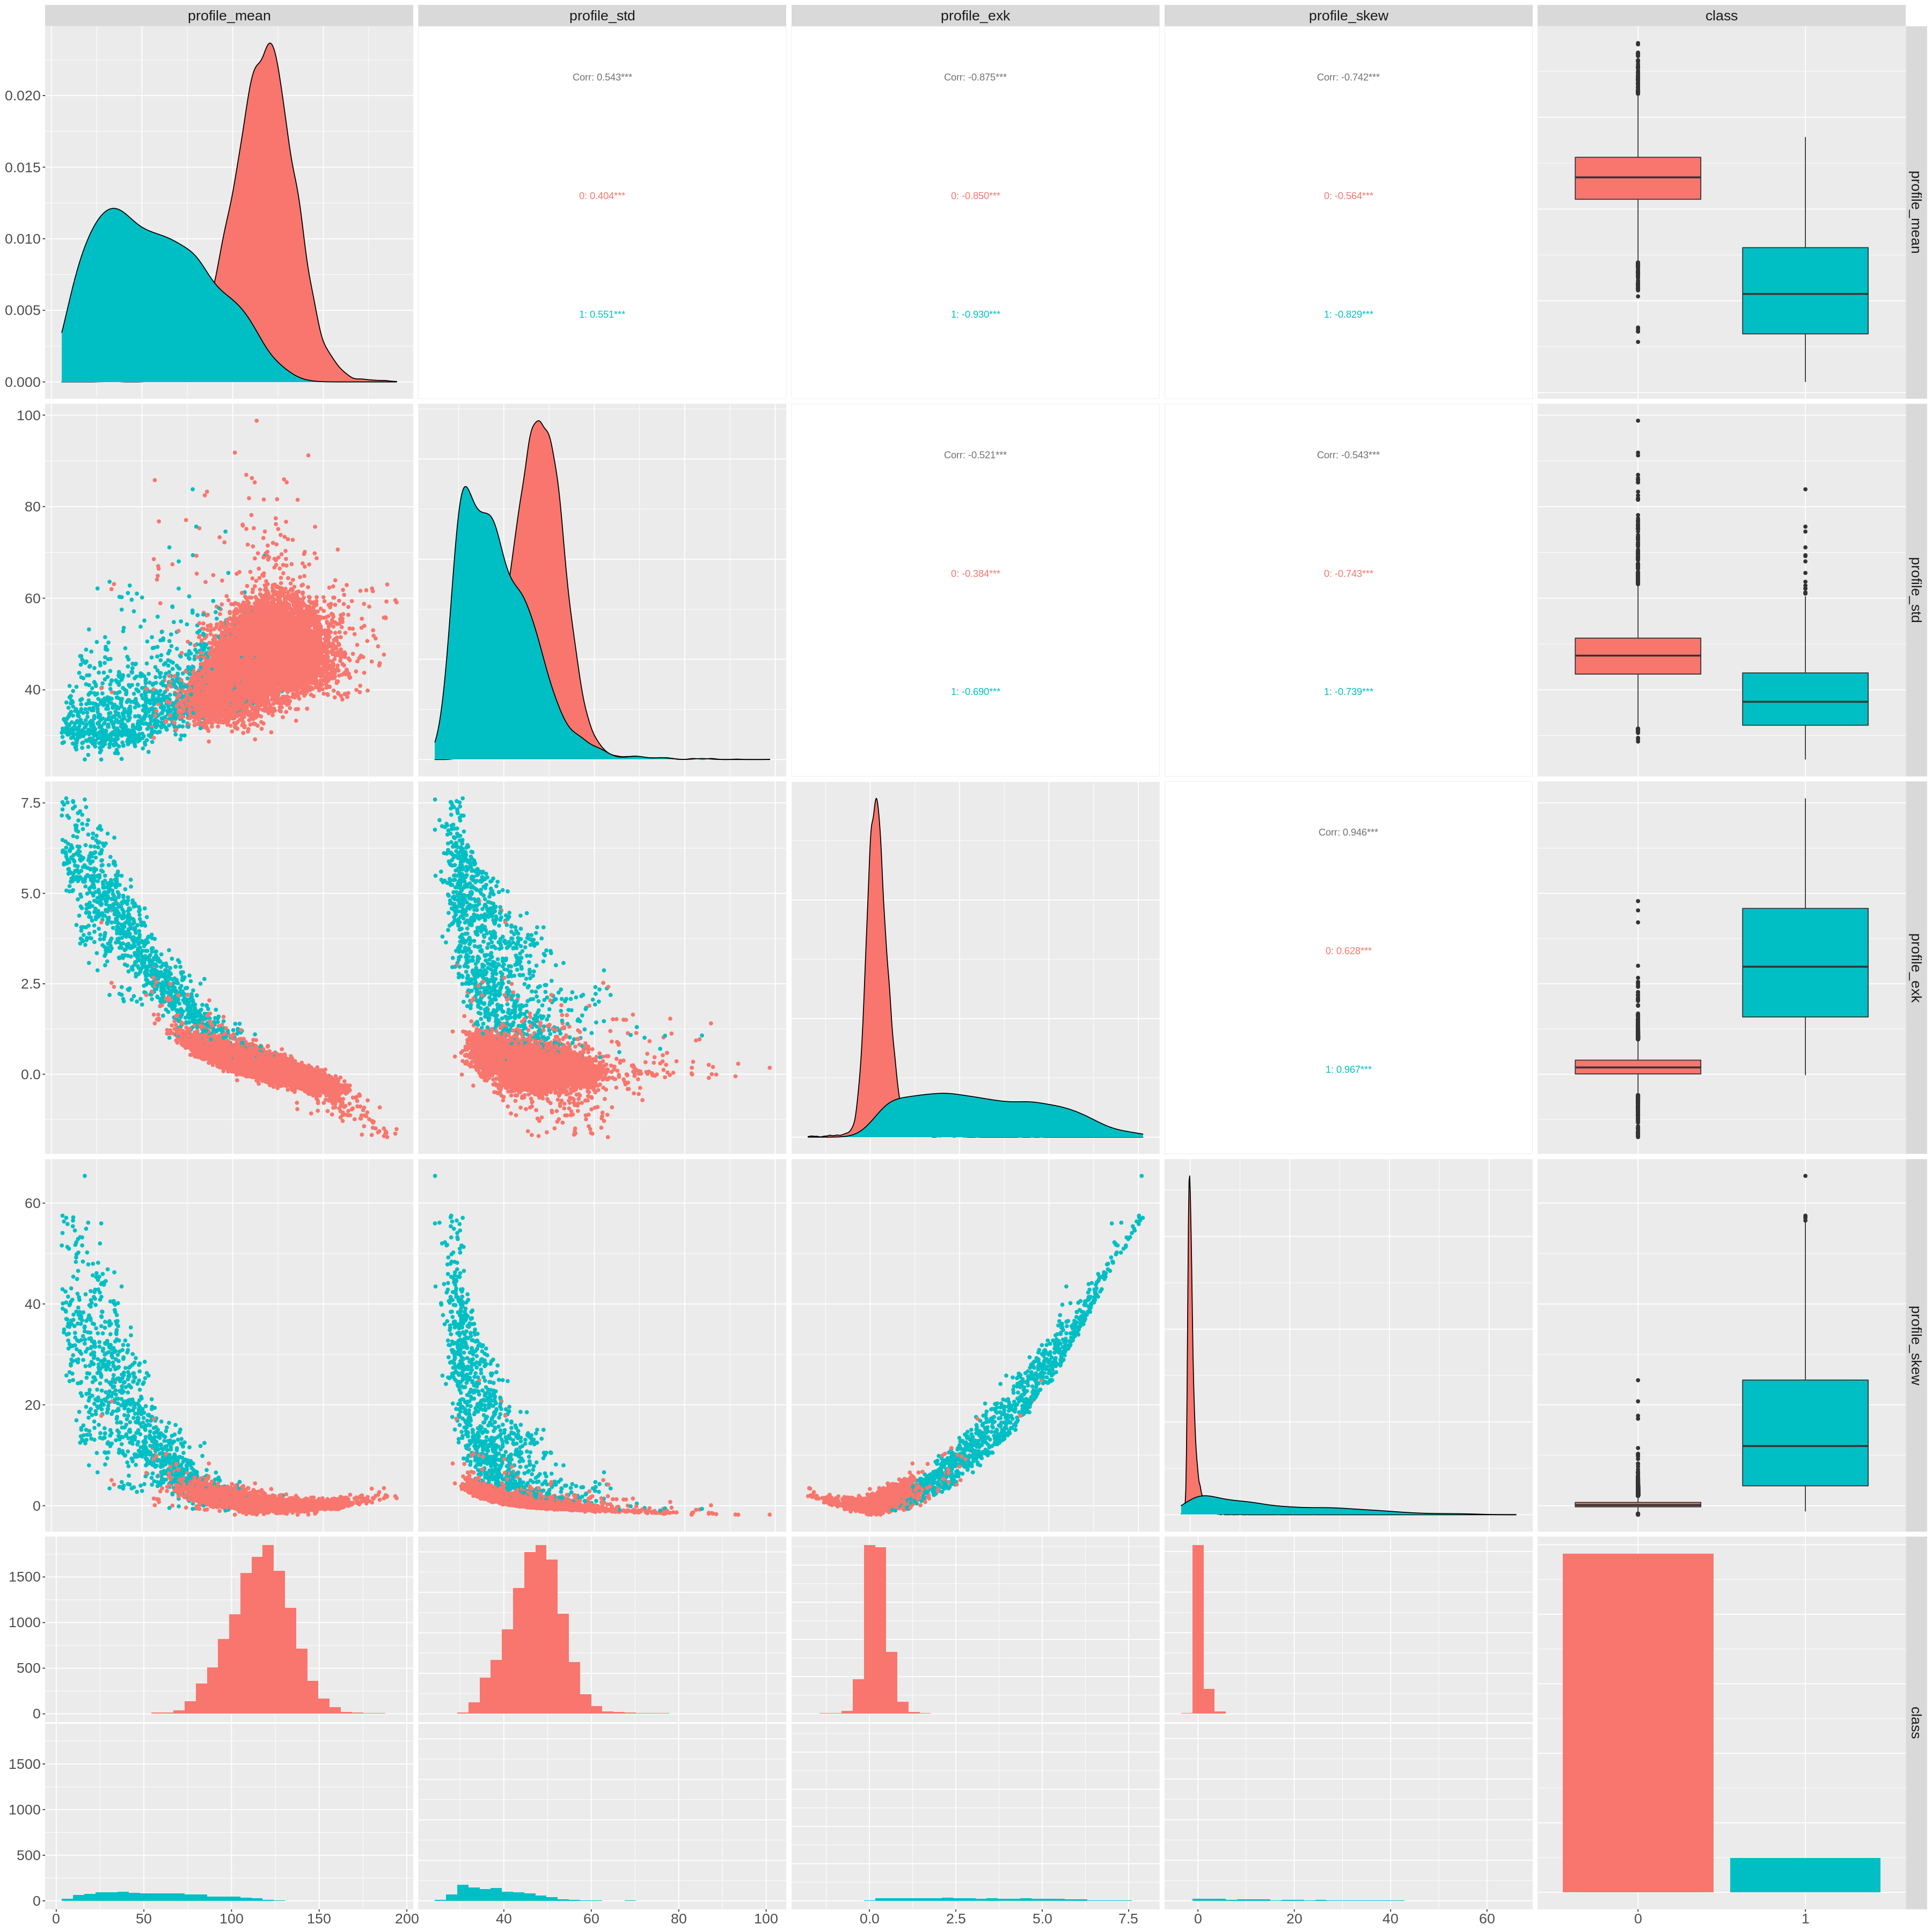

In [6]:
analysis_plot_profile <- signals_training |>
                select(!curve_mean:curve_skew) |>
                ggpairs(aes(color = class)) +
                theme(text = element_text(size = 20))
options(repr.plot.width = 30, repr.plot.height = 30) 
analysis_plot_profile

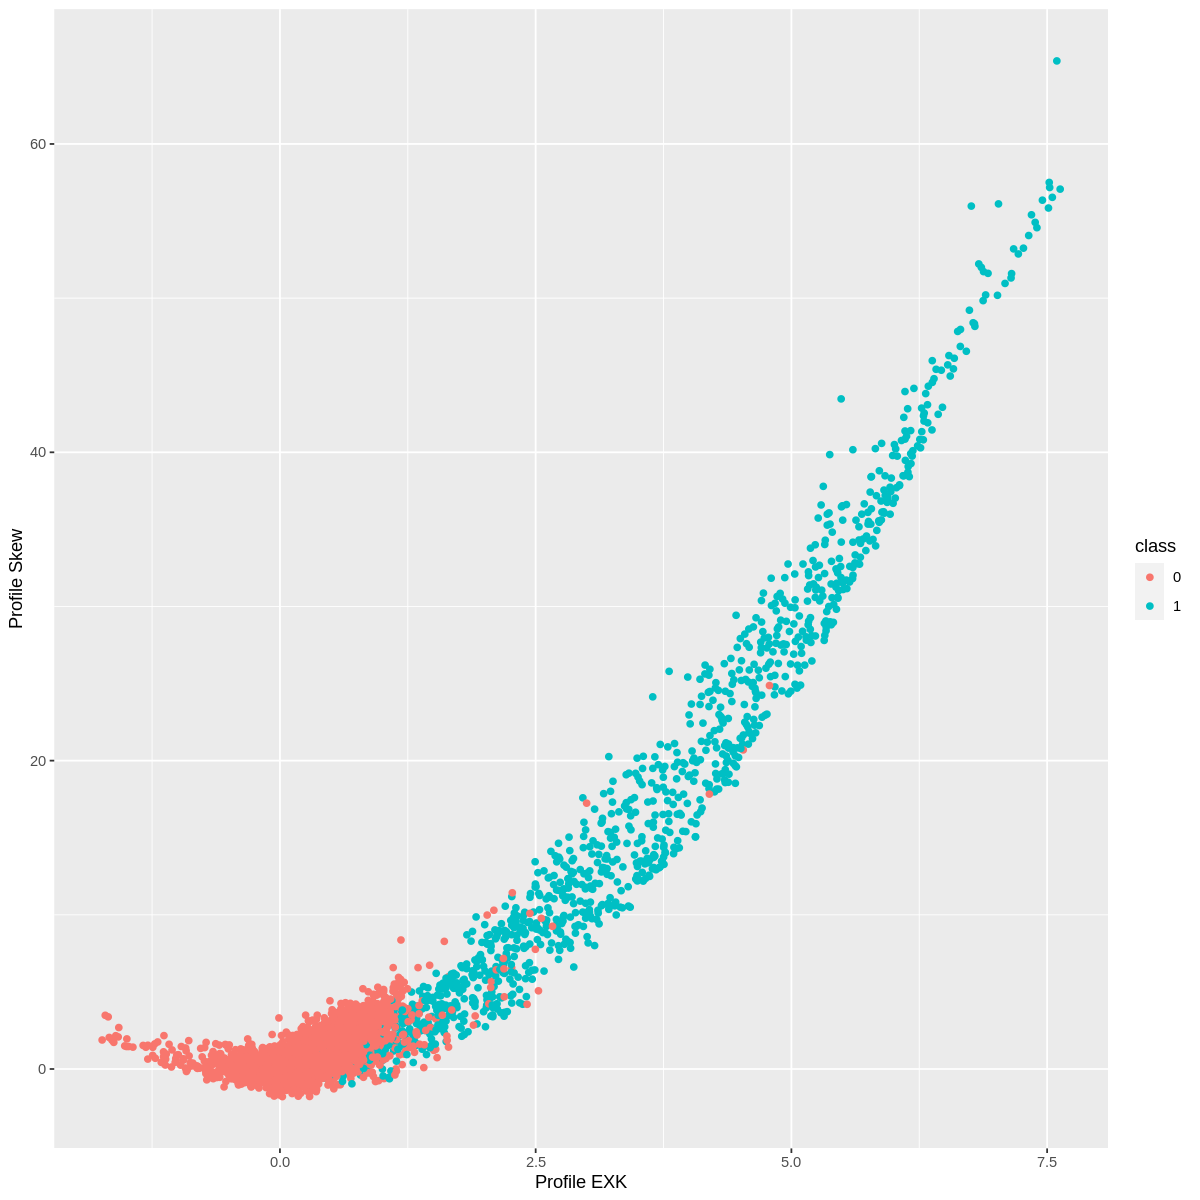

In [9]:
peks_pskew_plot <- signals_training |>
                    ggplot(aes(x=profile_exk, y=profile_skew, color = class)) + 
                    geom_point() + 
                    xlab("Profile EXK") +
                    ylab("Profile Skew")
options(repr.plot.width = 10, repr.plot.height = 10) #readjusts plot size 

peks_pskew_plot

### Methods

For the data analysis, we will perform classification using the variables profile_mean, profile_std, profile_exk and profile_skew. The curve variables will be omitted for the classification as the pairs analysis demonstrated that the curve_mean, curve_std, curve_exk and the curve_skew render visualizations that do not separate the pulsar star points and the non-pulsar star points clearly.

For the classification, we will use the K-nearest neighbors algorithm in R to code a classifier that will determine whether a given observation classifies as a pulsar star or not. We will first preprocess the data by creating a recipe for the model, then train our classifier by defining a model specification using the K-nearest neighbors function in R, fit the specification onto our dataset using the fit function, then combine everything together using the workflow function. We will then apply cross validation onto our training data to determine the value of K that will render the greatest accuracy, then test the model using our testing dataset to determine whether our model is satisfactory.

We will visualize the results by creating a scatterplot with profile_exk plotted on the x-axis and profile_skew plotted on the y-axis, then demonstrate with observations in our testing dataset whether our model does a good job of classifying the observations onto the plot. 

### Hypothesis (Expected outcomes and significance)

We expect to classify observations as a pulsar or not a pulsar. 

Pulsars are being used by scientists to investigate the most extreme forms of matter, look for extrasolar planets, and measure cosmic distances. Pulsars may also aid in the discovery of gravitational waves, which may lead to the detection of powerful cosmic occurrences like the collisions of supermassive black holes. This classification model can help scientists with their research by quickly analysing new observations for pulsar stars that may be useful for their research.

In the future, we may be able to use models similar to this one to classify pulsars more usefully, giving information on which pulsars are especially useful in research due to properties based on its radio signal.